# Imports and configs

In [11]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from random import gauss
from random import seed
from pandas import Series
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from plotly.subplots import make_subplots
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA


In [2]:
airline_passengers_data_path = "https://storage.googleapis.com/edulabs-public-datasets/airline-passengers.csv"
shampoo_sales_data_path = "https://storage.googleapis.com/edulabs-public-datasets/shampoo-sales.csv"

#This dataset describes the minimum daily temperatures over 10 years (1981-1990) in the city Melbourne, Australia.
dayly_minimum_temp_data_path = "https://storage.googleapis.com/edulabs-public-datasets/daily-minimum-temperatures.csv"

# number of daily female births in California in 1959
dayly_total_female_births_data_path = "https://storage.googleapis.com/edulabs-public-datasets/daily-total-female-births.csv"

In [3]:
pd.options.plotting.backend = "matplotlib"


# Load Data

In [4]:
airline_df = pd.read_csv(airline_passengers_data_path, parse_dates=["Month"])
from datetime import datetime
def parser(x):
    return datetime.strptime('199'+x, '%Y-%m')
sales_df = pd.read_csv(shampoo_sales_data_path, parse_dates=['Month'], date_parser=parser, index_col='Month')
births_df = pd.read_csv(dayly_total_female_births_data_path, parse_dates=["Date"])
temp_df = pd.read_csv(dayly_minimum_temp_data_path, parse_dates=["Date"])


<ipython-input-4-39f33bb9c9d5>:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  sales_df = pd.read_csv(shampoo_sales_data_path, parse_dates=['Month'], date_parser=parser, index_col='Month')


In [23]:
births_df

,Date,Births
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44
...,...,...
360,1959-12-27,37
361,1959-12-28,52
362,1959-12-29,48
363,1959-12-30,55


In [24]:
ts = births_df.set_index('Date').squeeze()
ts = ts.asfreq('D')
ts = ts.interpolate(method='linear')
ts

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44
...,...
1959-12-27,37
1959-12-28,52
1959-12-29,48


#Visualize the Series

<Axes: xlabel='Date'>

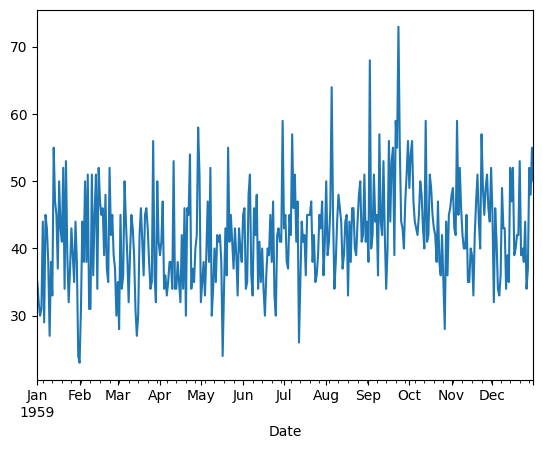

In [25]:
ts.plot()

# Check for Stationarity

In [26]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(ts)
print(f'p-value: {result[1]}')

p-value: 5.2434129901498554e-05


Stationary!

# Difference the Series (if needed)

- Apply differencing until stationarity is achieved
- Repeat if needed: ts.diff(2), etc.
- Set d = number of differences used

In [ ]:
# no need here - already stationary!

# Plot ACF and PACF to determine q and p

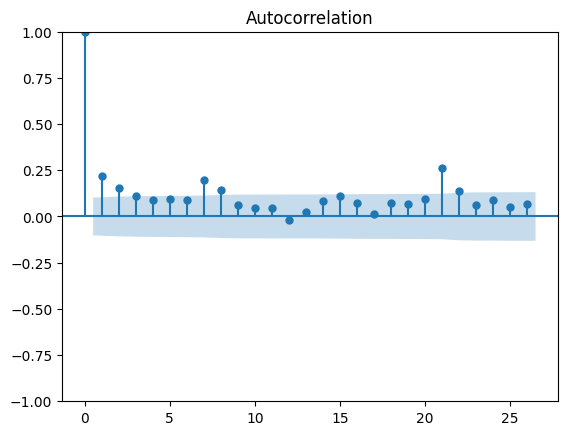

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts)

plt.show()

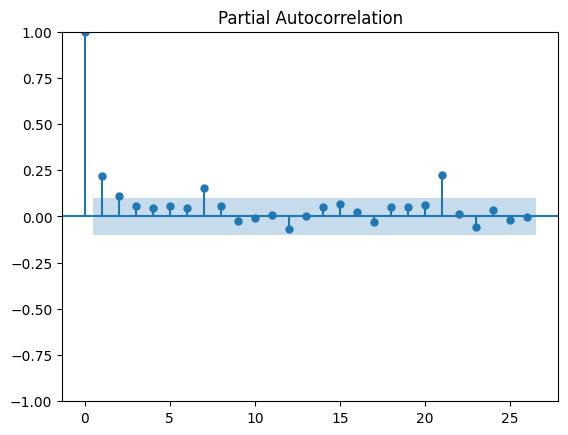

In [28]:
plot_pacf(ts)
plt.show()

# Select (p, d, q)
- Use ACF → suggest 𝑞
- Use PACF → suggest 𝑝
- Use differencing step → gives 𝑑

In [29]:
# p = 2
# q = 0
# d = 0

p = 1
q = 1
d = 0

# Fit the ARIMA Model

In [30]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(ts, order=(p, d, q))
result = model.fit()
print(result.summary())


                               SARIMAX Results                                
Dep. Variable:                 Births   No. Observations:                  365
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1230.453
Date:                Mon, 12 May 2025   AIC                           2468.906
Time:                        06:57:35   BIC                           2484.505
Sample:                    01-01-1959   HQIC                          2475.105
                         - 12-31-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.8289      1.438     29.079      0.000      39.010      44.648
ar.L1          0.9800      0.017     56.392      0.000       0.946       1.014
ma.L1         -0.9199      0.035    -26.294      0.0

# Check Residuals

Residuals should be white noise

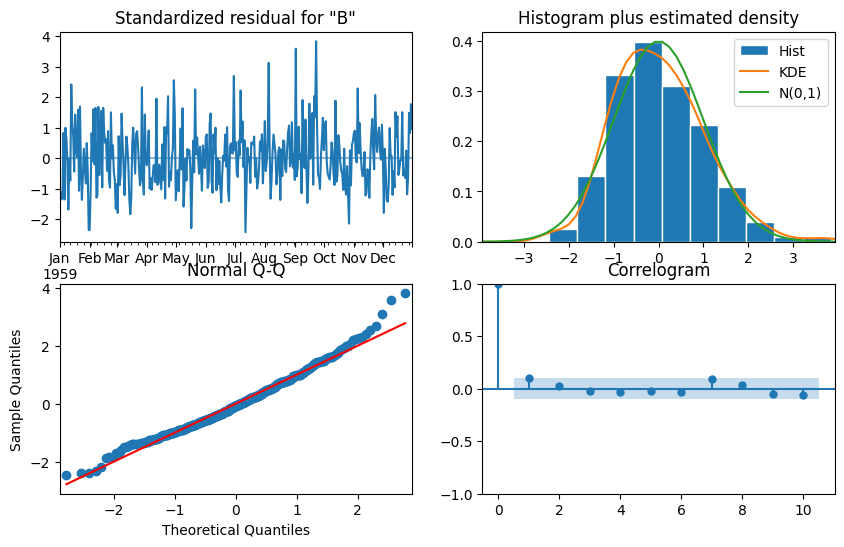

In [31]:
result.plot_diagnostics(figsize=(10, 6))
plt.show()

# Using ARIMA with TimeSeries CV

In [12]:
# Expanding window
tscv = TimeSeriesSplit(n_splits=5)

In [20]:
for fold, (train_idx, test_idx) in enumerate(tscv.split(ts)):
    print(f"Fold {fold + 1}: Train shape: {train_idx.shape}, test shape: {test_idx.shape}")
    print(f"Train index start: {train_idx[0]}, end: {train_idx[-1]}")
    print(f"Test index start: {test_idx[0]}, end: {test_idx[-1]}")

Fold 1: Train shape: (612,), test shape: (608,)
Train index start: 0, end: 611
Test index start: 612, end: 1219
Fold 2: Train shape: (1220,), test shape: (608,)
Train index start: 0, end: 1219
Test index start: 1220, end: 1827
Fold 3: Train shape: (1828,), test shape: (608,)
Train index start: 0, end: 1827
Test index start: 1828, end: 2435
Fold 4: Train shape: (2436,), test shape: (608,)
Train index start: 0, end: 2435
Test index start: 2436, end: 3043
Fold 5: Train shape: (3044,), test shape: (608,)
Train index start: 0, end: 3043
Test index start: 3044, end: 3651


In [32]:
# Define model order (for ARIMA)
p, d, q = 2, 0, 0

# Setup time series split (5 folds)
tscv = TimeSeriesSplit(n_splits=5)
errors = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(ts)):
    train, test = ts.iloc[train_idx], ts.iloc[test_idx]

    # Fit ARIMA on training data
    try:
        model = ARIMA(train, order=(p, d, q))
        result = model.fit()

        # Forecast the length of the test set
        forecast = result.forecast(steps=len(test))

        # Evaluate forecast
        mse = mean_squared_error(test, forecast)
        errors.append(mse)
        print(f"Fold {fold + 1}: MSE = {mse:.4f}")
    except:
        print(f"Fold {fold + 1}: model failed")
        continue

print(f"\nAverage MSE across folds: {np.mean(errors):.4f}")


Fold 1: MSE = 45.7031
Fold 2: MSE = 39.6840
Fold 3: MSE = 56.1557
Fold 4: MSE = 85.2656
Fold 5: MSE = 44.8566

Average MSE across folds: 54.3330


# ARIMA Grid Search

In [33]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")



# Candidate parameters
p_values = [1, 2]
d_values = [0]
q_values = [0, 1]

# CV Setup
tscv = TimeSeriesSplit(n_splits=5)

# Search
best_score = float("inf")
best_order = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            mse_list = []
            for train_idx, test_idx in tscv.split(ts):
                train, test = ts.iloc[train_idx], ts.iloc[test_idx]
                try:
                    model = ARIMA(train, order=(p, d, q)).fit()
                    forecast = model.forecast(steps=len(test))
                    mse = mean_squared_error(test, forecast)
                    mse_list.append(mse)
                except:
                    break  # Skip failed models
            if len(mse_list) == tscv.get_n_splits():
                avg_mse = np.mean(mse_list)
                print(f"ARIMA({p},{d},{q}) MSE = {avg_mse:.3f}")
                if avg_mse < best_score:
                    best_score = avg_mse
                    best_order = (p, d, q)

print(f"\n✅ Best order: ARIMA{best_order} with average MSE = {best_score:.3f}")


ARIMA(1,0,0) MSE = 54.340
ARIMA(1,0,1) MSE = 54.231
ARIMA(2,0,0) MSE = 54.333
ARIMA(2,0,1) MSE = 54.068

✅ Best order: ARIMA(2, 0, 1) with average MSE = 54.068


In [34]:
# check statistics for best order
model = ARIMA(ts, order=(2, 0, 1))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                 Births   No. Observations:                  365
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1228.142
Date:                Mon, 12 May 2025   AIC                           2466.283
Time:                        06:58:34   BIC                           2485.783
Sample:                    01-01-1959   HQIC                          2474.033
                         - 12-31-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.7926      1.712     24.417      0.000      38.438      45.147
ar.L1          1.1111      0.067     16.576      0.000       0.980       1.243
ar.L2         -0.1206      0.062     -1.941      0.0

# Predictions

In [36]:
ts

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44
...,...
1959-12-27,37
1959-12-28,52
1959-12-29,48


In [37]:
result.predict(start=len(ts), end=len(ts)+11)

,predicted_mean
1960-01-01,44.159445
1960-01-02,43.432720
1960-01-03,43.329557
1960-01-04,43.302568
1960-01-05,43.285020
1960-01-06,43.268777
1960-01-07,43.252845
1960-01-08,43.237101
1960-01-09,43.221529
1960-01-10,43.206125
